# Projet 2

## consigne

Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

Voici les différentes questions que Mark aimerait explorer, que vous avez notées durant la réunion :

 - Quels sont les pays avec un fort potentiel de clients pour nos services ?
 - Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
 - Dans quels pays l'entreprise doit-elle opérer en priorité ?
Votre mission
Mark vous a donc demandé de réaliser une analyse pré-exploratoire de ce jeu de données. Il vous a transmis cet email à la suite de la réunion :

***
Hello,

Les données de la Banque mondiale sont disponibles à l’adresse suivante :

https://datacatalog.worldbank.org/dataset/education-statistics

Ou en téléchargement direct à ce lien.

Je te laisse regarder la page d'accueil qui décrit le jeu de données. En résumé, l’organisme “EdStats All Indicator Query” de la Banque mondiale répertorie 4000 indicateurs internationaux décrivant l’accès à l’éducation, l’obtention de diplômes et des informations relatives aux professeurs, aux dépenses liées à l’éducation... Tu trouveras plus d'info sur ce site :

http://datatopics.worldbank.org/education/

Pour la pré-analyse, pourrais-tu :

 - Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)
 - Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)
 - Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)
 - Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)
 
Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !
***

Livrables attendus
 - Un notebook comportant les analyses pré-exploratoires réalisées (non cleané, pour comprendre votre démarche).
 - Un support de présentation pour la soutenance.

## import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
import ipywidgets as widgets

from datetime import datetime, timezone, timedelta, date
from IPython.display import display as Idisplay
from ipywidgets.embed import embed_minimal_html

import warnings
warnings.filterwarnings('ignore')

## import des données

In [2]:
EdStatsCountry = pd.read_csv("csv_data/EdStatsCountry.csv")
EdStatsCountry_Series = pd.read_csv("csv_data/EdStatsCountry-Series.csv")
EdStatsData = pd.read_csv("csv_data/EdStatsData.csv")
EdStatsFootNote = pd.read_csv("csv_data/EdStatsFootNote.csv")
EdStatsSeries = pd.read_csv("csv_data/EdStatsSeries.csv")

## premier regard sur les données

premier coup d'oeuil avec une carte des liens entre les tables

![title](table_chart.png)

***
### affichage des données manquantes sous forme de matrice binaire (Noir = manquant, Blanc = présent)

In [3]:
Tables = [EdStatsCountry, EdStatsCountry_Series, EdStatsData, EdStatsFootNote, EdStatsSeries]
T_Names = ["EdStatsCountry", "EdStatsCountry-Series", "EdStatsData", "EdStatsFootNote", "EdStatsSeries"]
for t,n in zip(Tables, T_Names):
    t.name = n
Stats = {}

def draw_missing_values(t, height=7):
    fig, ax = plt.subplots(figsize=(9,height))
    check = np.vectorize(lambda x : x!=x)
    Stats[t.name] = {"missing" : check(t.to_numpy()), "data" : t}
    msno.matrix(t, ax=ax, sparkline=False)
    ax.set_title(t.name)
    fig.tight_layout(pad=2)

<IPython.core.display.Javascript object>


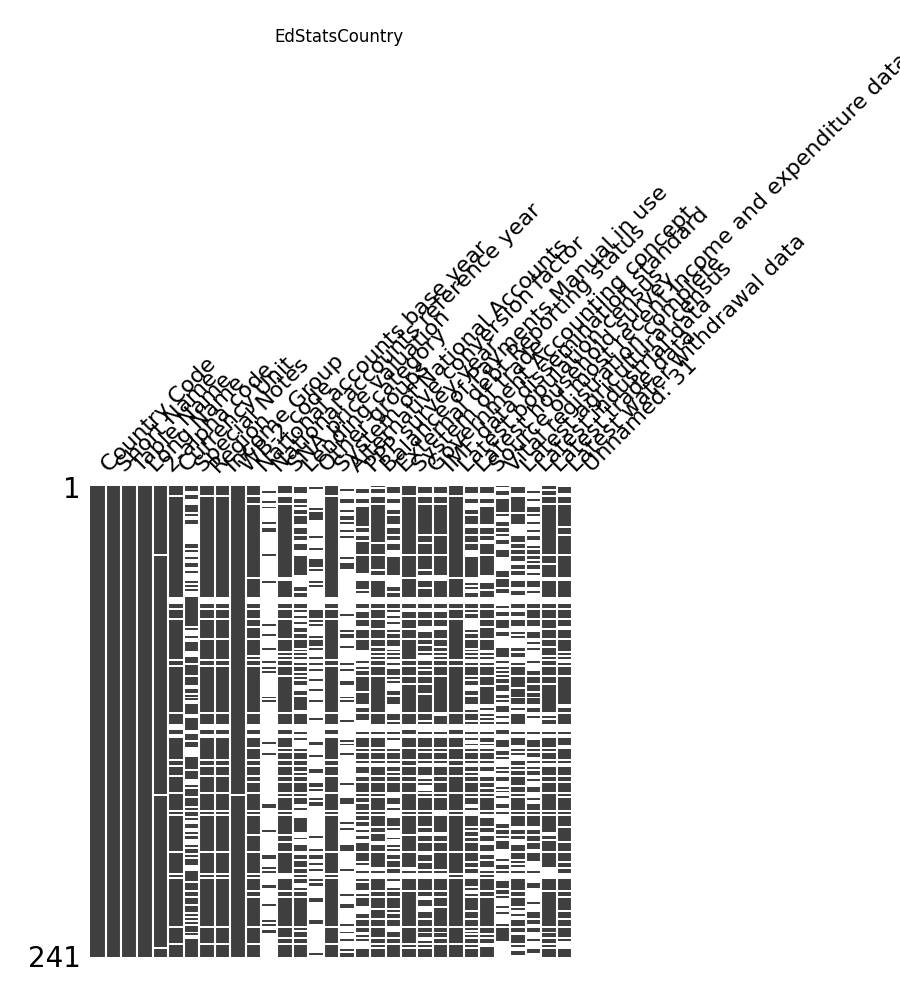

In [4]:
draw_missing_values(EdStatsCountry, 10)

<IPython.core.display.Javascript object>


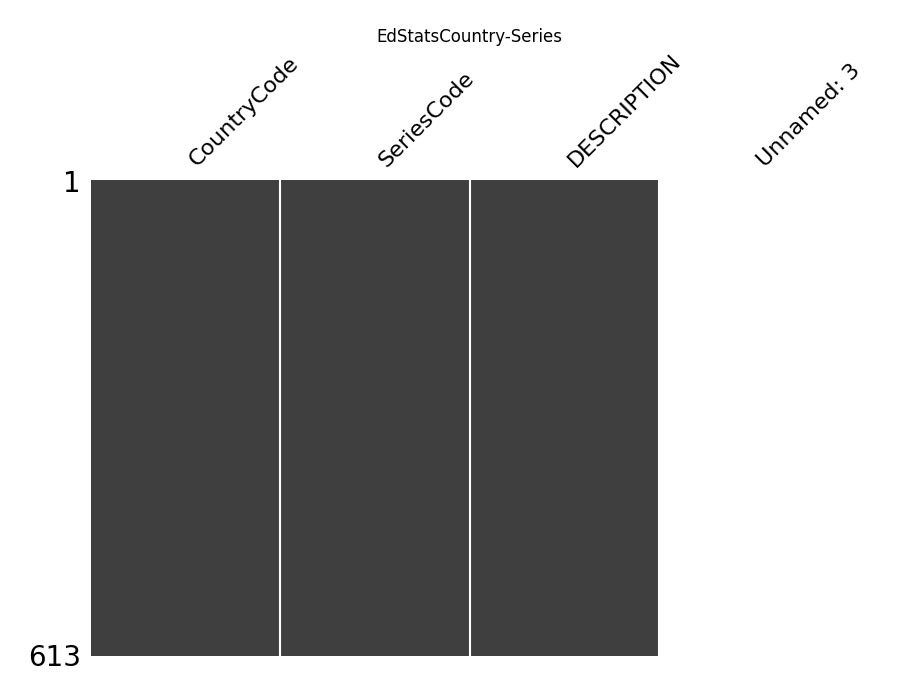

In [5]:
draw_missing_values(EdStatsCountry_Series)

<IPython.core.display.Javascript object>


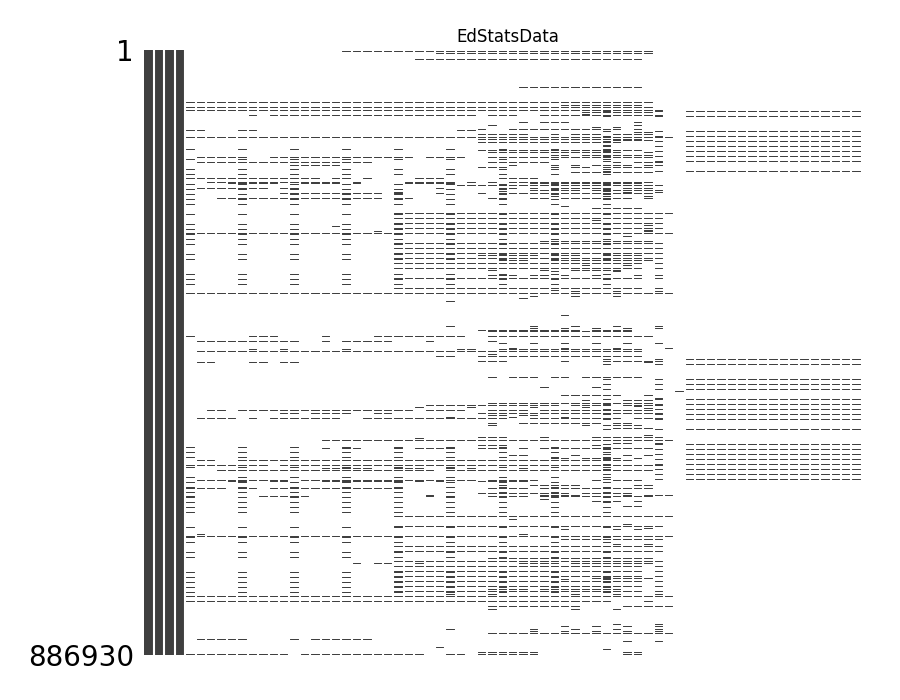

In [6]:
draw_missing_values(EdStatsData)

<IPython.core.display.Javascript object>


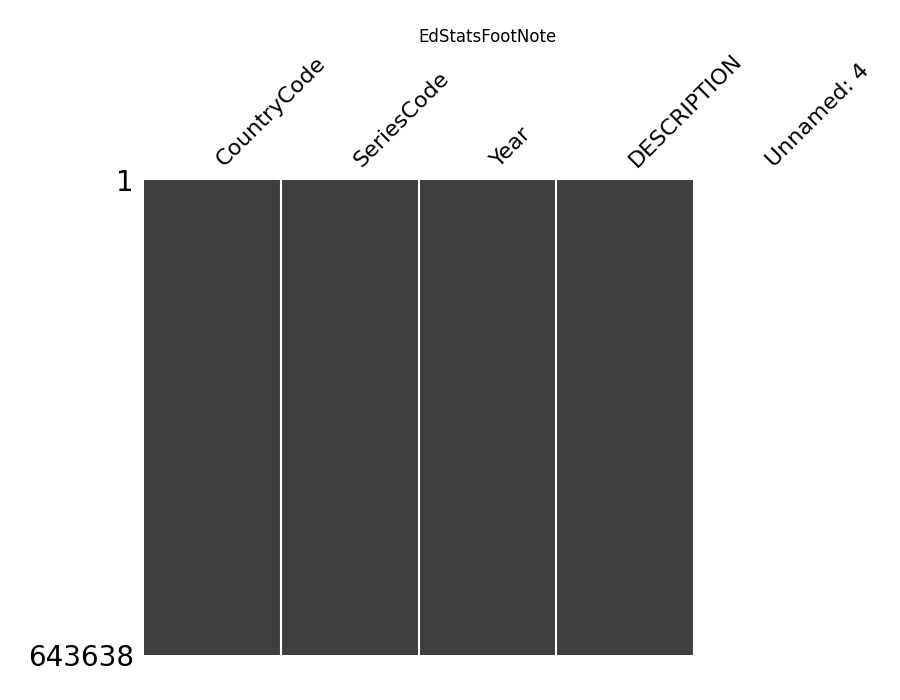

In [7]:
draw_missing_values(EdStatsFootNote)

<IPython.core.display.Javascript object>


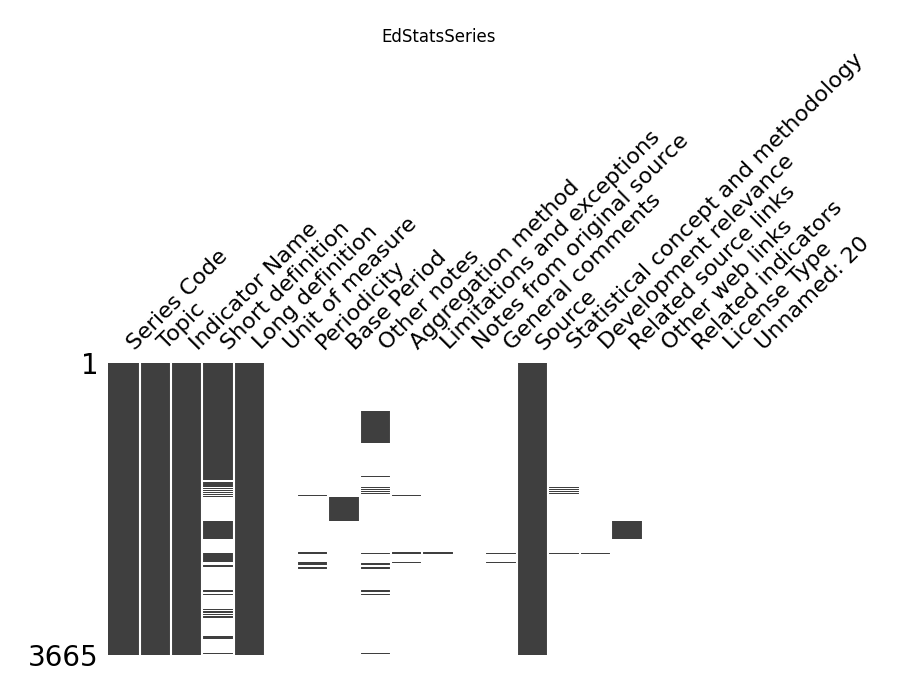

In [8]:
draw_missing_values(EdStatsSeries)

***
### sélection des indicateurs pertinents

In [9]:
indicators = ["Internet users (per 100 people)",
              "GNI per capita, Atlas method (current US$)",
              "Population, total",
              "Labor force, total",
              "Unemployment, total (% of total labor force)"]

selection_mask = np.array([n in indicators for n in EdStatsSeries["Indicator Name"]])
selection_codes = EdStatsSeries["Series Code"][selection_mask].to_numpy()

#countries = np.unique(EdStatsData["Country Name"].to_numpy())
countries = ["France", "United Kingdom"]

code_mask = np.array([c in selection_codes for c in EdStatsData["Indicator Code"]])
state_mask = np.array([c in countries for c in EdStatsData["Country Name"]])

In [10]:
def get_Y_values(dataframe, indicator, country, X_string):
    indicator_mask = np.array([i == indicator for i in EdStatsData["Indicator Name"]])
    country_mask = np.array([c == country for c in EdStatsData["Country Name"]])
    return EdStatsData[X_string][indicator_mask*country_mask].to_numpy().ravel()

In [11]:
X = [datetime(year, 1, 1) for year in list(range(1970,2018,1))+list(range(2020,2101,5))]
X_string = [str(x.year) for x in X]


to_plot = pd.DataFrame()
to_plot.index = X
for code in indicators:
    Y = get_Y_values(EdStatsData, code, "France", X_string)
    to_plot[code] = Y

In [12]:
start_date = widgets.NaiveDatetimePicker(description="date de début", value=min(X))
end_date = widgets.NaiveDatetimePicker(description="date de fin", value=max(X))
indicator_checkboxes = [widgets.Checkbox(description=i, value=False) for i in indicators]
accordion = widgets.Accordion(children=[widgets.VBox(indicator_checkboxes)], selected_index = None)
accordion.set_title(0, "Indicateurs")

Boxes_states = {k:False for k in selection_codes}

In [13]:
COLORMAP = {}

In [18]:
class Displayer :
    DEFAULT_COLORS = COLORMAP
    
    def __init__(self, DS, fig, axis):
        self.dataset = DS
        self.X = X
        self.d_start = min(self.X)
        self.d_end = max(self.X)
        self.mask = np.full(len(self.X), True)
        self.plot_func = "plot"
        self.fig = fig
        self.ax = axis
        self.colors = self.DEFAULT_COLORS
        self.out = widgets.Output()
    
    def edit_colormap(self, key, color):
        self.colors[key] = color
    
    def change_plot_func(self, new_func):
        self.plot_func = new_func
    
    def change_dates(self, new_date_start=None, new_date_end=None):
        if new_date_start :
            self.d_start = new_date_start
        if new_date_end :
            self.d_end = new_date_end
        self._UPDATE_MASK()
    
    def _UPDATE_MASK(self):
        self.mask = np.array([self.d_start <= date <= self.d_end for date in self.X])
    
    def _PLOT(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        for col,val in Boxes.items() :
            if val :
                ax.plot(self.X, 
                        self.dataset[col],
                        label=col,
                        zorder=1)
        
        ax.tick_params(axis='x', rotation=90)
        ax.grid(zorder=0)
        ax.legend()
        fig.tight_layout()
        plt.show()
    
    def _SCATTER(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        for col,val in Boxes.items() :
            if val :
                ax.scatter(self.X[M], 
                           self.dataset[col],
                           s=list([50,20,5]+[1]*5)[int(np.log10(len(self.X[M])))],
                           label=col,
                           zorder=1)
        ax.tick_params(axis='x', rotation=90)
        ax.grid(zorder=0)
        ax.legend()
        fig.tight_layout()
        plt.show()
    
    def _BOXPLOT(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        input_data = {}
        for col,val in Boxes.items() :
            if val :
                input_data[col] = self.dataset[col]
        ax.boxplot(x=input_data.values(), 
                   vert=True,
                   labels = input_data.keys(), 
                   meanline=True,
                   sym='')
        
        ax.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.show()
    
    def _VIOLINPLOT(self, Boxes):
        fig, ax = self.fig, self.ax
        ax.clear()
        input_data = {}
        for col,val in Boxes.items() :
            if val :
                input_data[col] = self.dataset[col]
        sns.violinplot(data=list(input_data.values()),
                       ax=ax)
        
        ax.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.show()

    def display(self, Boxes):
        self.out.clear_output()
        with self.out :
            if self.plot_func == "plot" :
                self._PLOT(Boxes)
            if self.plot_func == "scatter" :
                self._SCATTER(Boxes)
            if self.plot_func == "boxplot" :
                self._BOXPLOT(Boxes)
            if self.plot_func == "violinplot" :
                self._VIOLINPLOT(Boxes)
        Idisplay(self.out)

<IPython.core.display.Javascript object>


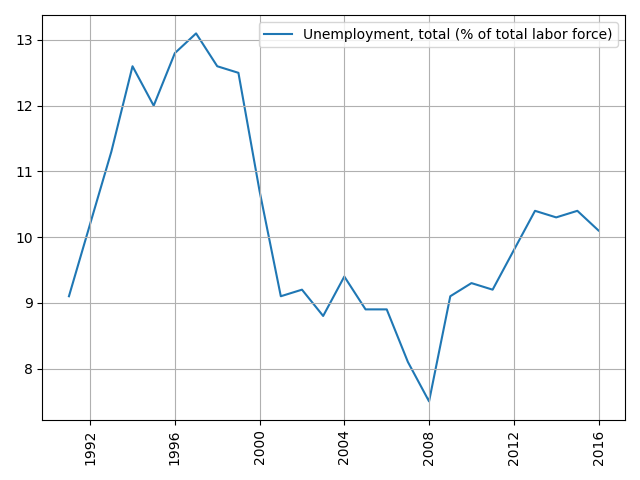

NaiveDatetimePicker(value=datetime.datetime(1970, 1, 1, 0, 0), description='date de début')

NaiveDatetimePicker(value=datetime.datetime(2100, 1, 1, 0, 0), description='date de fin')

Accordion(children=(VBox(children=(Checkbox(value=True, description='Internet users (per 100 people)'), Checkb…

Output()

Output()

Output()

Output(outputs=({'output_type': 'stream', 'text': 'No artists with labels found to put in legend.  Note that a…

Output(outputs=({'output_type': 'stream', 'text': 'No artists with labels found to put in legend.  Note that a…

Output(outputs=({'output_type': 'stream', 'text': 'No artists with labels found to put in legend.  Note that a…

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [19]:
fig, ax = plt.subplots()

D = Displayer(to_plot, fig, ax)

def start_date_eventhandler(change):
    D.change_dates(change.new)
    D.display(Boxes_states)
def end_date_eventhandler(change):
    D.change_dates(new_date_end=change.new)
    D.display(Boxes_states)
def checkboxes_column_eventhandler(desc, change):
    if isinstance(change['new'], dict) and change['new'] :
        Boxes_states[desc]=change['new']['value']
        D.display(Boxes_states)
def checkbox_eventhandler(change):
    checkboxes_column_eventhandler(change['owner'].description, change)

start_date.observe(start_date_eventhandler, names='value')
end_date.observe(end_date_eventhandler, names='value')
for el in indicator_checkboxes :
    el.observe(checkbox_eventhandler)

Idisplay(start_date, end_date, accordion)